TF serving demo:
* train a keras model with multiple outputs
* serve the model
    * compare timing with in-memory timing

In [1]:
!ls

data  demo.ipynb  README.md  vanilla.ipynb


In [2]:
!nvidia-smi

Fri Jul 20 17:23:09 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.37                 Driver Version: 396.37                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   46C    P8    12W / 120W |   5927MiB /  6076MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
# 1. Store a text file for train generator

In [4]:
import os
import numpy as np
import pandas as pd

def flatten(l): return [item for sublist in l for item in sublist]

In [5]:
# Read dataframe
df_train = pd.read_csv("./data/train_v2.csv")

# Make label maps
labels = sorted(list(set(flatten([l.split(' ') for l in df_train['tags'].values]))))

weather_labels = ['clear', 'cloudy', 'haze', 'partly_cloudy']
ground_labels = [l for l in labels if l not in weather_labels]

N_WLAB = len(weather_labels)
N_GLAB = len(ground_labels)

label_map = {l:i for i, l in enumerate(labels)}
wlabel_map = {l: i for i, l in enumerate(weather_labels)}
glabel_map = {l: i for i, l in enumerate(ground_labels)}

In [6]:
def get_labels_binary(s, labelmap):
    labels = np.zeros(len(labelmap), dtype=np.int64)
    idx = [v for v in [labelmap[w] for w in s.split(' ')]]
    labels[idx] = 1
    return labels

def array_to_str(arr):
    return(str(arr.tolist()))

In [7]:
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


{'clear': 0, 'cloudy': 1, 'haze': 2, 'partly_cloudy': 3}

In [13]:
df_train['label'] = df_train['tags'].apply(get_labels_binary, args=(label_map,))
df_train['wlabel'] = df_train['tags'].apply(get_labels_binary, args=(wlabel_map,))
df_train['glabel'] = df_train['tags'].apply(get_labels_binary, args=(glabel_map,))

> <ipython-input-11-ad38f88b2674>(1)<module>()
----> 1 labelmap

ipdb> wher
*** NameError: name 'wher' is not defined
ipdb> help

Documented commands (type help <topic>):
EOF    cl         disable  interact  next    psource  rv         unt   
a      clear      display  j         p       q        s          until 
alias  commands   down     jump      pdef    quit     source     up    
args   condition  enable   l         pdoc    r        step       w     
b      cont       exit     list      pfile   restart  tbreak     whatis
break  continue   h        ll        pinfo   return   u          where 
bt     d          help     longlist  pinfo2  retval   unalias  
c      debug      ignore   n         pp      run      undisplay

Miscellaneous help topics:
exec  pdb

ipdb> q


KeyError: 'primary'

In [12]:
label_map

{'agriculture': 0,
 'artisinal_mine': 1,
 'bare_ground': 2,
 'blooming': 3,
 'blow_down': 4,
 'clear': 5,
 'cloudy': 6,
 'conventional_mine': 7,
 'cultivation': 8,
 'habitation': 9,
 'haze': 10,
 'partly_cloudy': 11,
 'primary': 12,
 'road': 13,
 'selective_logging': 14,
 'slash_burn': 15,
 'water': 16}

In [9]:
# there is a single instance without weather label -> remove it
missing_w_idx = np.where(np.array([np.sum(v) for v in df_train['wlabel'].values]) != 1.0)[0][0]
df_train = df_train.drop(index=missing_w_idx, axis=0)

KeyError: 'wlabel'

In [8]:
# Map everything to strings
df_train['label']  = df_train['label'].map(array_to_str)
df_train['wlabel'] = df_train['wlabel'].map(array_to_str)
df_train['glabel'] = df_train['glabel'].map(array_to_str)

In [9]:
# Save as text file
df_train.drop('tags', axis=1).to_csv('./data/TRAIN.csv', index=None)

In [10]:
df_train.head()

,image_name,tags,label,wlabel,glabel
0,train_0,haze primary,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
1,train_1,agriculture clear primary water,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]"
2,train_2,clear primary,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
3,train_3,clear primary,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,train_4,agriculture clear habitation primary road,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, ...","[1, 0, 0, 0]","[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]"


In [72]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
import ast 

def randomHorizontalFlip(image, p=0.5):
    """Do a random horizontal flip with probability p"""
    if np.random.random() < p:
        image = np.fliplr(image)
    return image


def randomVerticalFlip(image, p=0.5):
    """Do a random vertical flip with probability p"""
    if np.random.random() < p:
        image = np.flipud(image)
    return image

class DataSet(object):
    """Custom generator"""

    def __init__(self, file_path, data_path, im_size, batch_size, shuffle, mode='train'):
        self.fp = file_path  # path to training file
        self.dp = data_path # path to raw images
        self.imsz = im_size
        self.bsz = batch_size
        self.shuf = shuffle
        self.mode = mode
        
        self.df = pd.read_csv(self.fp)
    
    def __len__(self):
        return len(self.df)
    
    def get_instance_indexes(self):
        indexes = list(self.df.index)
        if self.shuf:
            np.random.shuffle(indexes)
        return indexes

    def get_batch_features(self, indexes):
        batch_features = np.zeros((len(indexes), self.imsz, self.imsz, 3))

        # Fill up container
        for i, ix in enumerate(indexes):

            im = load_img(os.path.join(self.dp, self.df['image_name'][ix] + '.jpg'))
            w, h = im.size
            resize = max(self.imsz / w, self.imsz / h)
            # PIL .resize() requires size as (width, height)!
            newdim = (int(w * resize), int(h * resize))
            newim = im.resize(newdim)

            im = img_to_array(newim)
            im = im / 255.

            if True:
                im = randomHorizontalFlip(im)
                im = randomVerticalFlip(im)

            batch_features[i] = im

            return batch_features

    def get_batch_labels(self, indexes):
        if self.mode == 'test':
            return None
        else:
            # Empty containers for labels
            labels = np.zeros((len(indexes), 17))
            w_labels, g_labels = np.zeros((len(indexes), N_WLAB)), np.zeros((len(indexes), N_GLAB))
            # Fill up container
            for i, ix in enumerate(indexes):
                labels[i] = np.array(ast.literal_eval(self.df['label'][ix]), dtype=int)
                w_labels[i] = np.array(ast.literal_eval(
                    self.df['wlabel'][ix]), dtype=int)
                g_labels[i] = np.array(ast.literal_eval(
                    self.df['glabel'][ix]), dtype=int)
            #return [w_labels, g_labels]
            return labels
    def generate(self, mode='train'):
        self.mode = mode
        while True:
            indexes = self.get_instance_indexes()
            num_batches = int(np.ceil(len(self.df) / self.bsz))
            for i in range(num_batches):
                if i == (num_batches - 1):
                    batch_indexes = indexes[i * self.bsz:]
                else:
                    batch_indexes = indexes[i * self.bsz:(i + 1) * self.bsz]

                X = self.get_batch_features(batch_indexes)
                y = self.get_batch_labels(batch_indexes)
                yield (X, y)

In [73]:
# 3. Train a model
import math
import tensorflow as tf
import numpy as np
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer, Concatenate, Add, Subtract
from keras.layers import BatchNormalization, Dropout, Activation
from keras.layers import MaxPooling2D
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Multiply, Dot
from keras.layers import BatchNormalization
from keras.engine.topology import Layer
from keras.models import Model
from keras.applications import VGG16, ResNet50
import keras.backend as K
from keras import metrics

class VGG_classifier(object):
    def __init__(self, im_size, n_neurons, imagenet):
        self.im_size = im_size
        self.n_channels = 3
        self.n_neurons = n_neurons
        self.imagenet = imagenet
        self.build()

    def build(self):
        # Define input
        self.x = Input(shape=(self.im_size, self.im_size, 3))

        # Pretrained VGG16
        weights = None
        if self.imagenet:
            weights = 'imagenet'
        VGGmodel = VGG16(include_top=False, weights=weights,
                         input_tensor=self.x,
                         input_shape=(self.im_size, self.im_size, self.n_channels),
                         pooling='max')

        # VGG_out = Flatten()(VGGmodel.output) # in case of no pooling
        VGG_out = VGGmodel.output
        VGG_out = BatchNormalization()(VGG_out)
        VGG_out = Dropout(0.25)(VGG_out)

        # batchnorm + dense layers
        fc_1 = BatchNormalization()(Dense(self.n_neurons, activation='relu')(VGG_out))
        self.fc_1 = Dropout(0.25)(fc_1)
        self.weather = Dense(N_WLAB, activation='softmax', name='weather_labels')(self.fc_1)
        self.ground = Dense(N_GLAB, activation='sigmoid', name='ground_labels')(self.fc_1)
        self.model = Model(inputs=self.x, outputs=[self.weather, self.ground])
        
class CNN(object):
    def __init__(self, im_size):
        self.imsz = im_size
        self.build()
        
    def build(self):
        self.x = Input(shape=(self.imsz, self.imsz, 3))
        x = Conv2D(32, (3,3), activation='relu')(self.x)
        x = MaxPooling2D(padding='same')(x)
        x = Conv2D(32, (3,3), activation='relu')(x)
        x = MaxPooling2D(padding='same')(x)
        x = Flatten()(x)
        x = Dense(64, activation='relu')(x)
        #g = Dense(N_GLAB, activation='sigmoid', name='ground_labels')(x)
        #w = Dense(N_WLAB, activation='softmax', name='weather_labels')(x)
        l = Dense(17, activation='sigmoid', name='labels')(x)
        self.model = Model(inputs=self.x, outputs=l)

In [74]:
model = CNN(48).model
#model.compile(optimizer='sgd', loss={'weather_labels': 'categorical_crossentropy',
#                                     'ground_labels': 'binary_crossentropy'})
model.compile(loss='binary_crossentropy', optimizer='adam')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 46, 46, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3872)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                247872    
__________

In [75]:
batch_size = 16
ds = DataSet('./data/TRAIN.csv', './data/train/', im_size=48, batch_size=batch_size, shuffle=True)
generator = ds.generate()

In [76]:
next(generator)[0][0].shape

(48, 48, 3)

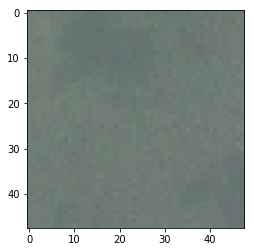

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots()
ax.imshow(next(generator)[0][0])

In [78]:
next(generator)[0][0]

array([[[0.52156866, 0.45490196, 0.40392157],
        [0.53333336, 0.45882353, 0.40392157],
        [0.50980395, 0.45882353, 0.40392157],
        ...,
        [0.35686275, 0.38039216, 0.33725491],
        [0.34901962, 0.37254903, 0.3137255 ],
        [0.33725491, 0.37254903, 0.32549021]],

       [[0.46666667, 0.42745098, 0.3764706 ],
        [0.43921569, 0.41960785, 0.37254903],
        [0.52549022, 0.47058824, 0.41176471],
        ...,
        [0.32941177, 0.36470589, 0.32156864],
        [0.33333334, 0.36862746, 0.30980393],
        [0.30588236, 0.34117648, 0.30980393]],

       [[0.49019608, 0.4509804 , 0.39215687],
        [0.4627451 , 0.43529412, 0.38431373],
        [0.50588238, 0.4627451 , 0.39607844],
        ...,
        [0.3019608 , 0.34901962, 0.30980393],
        [0.29803923, 0.32549021, 0.3019608 ],
        [0.3137255 , 0.34117648, 0.3019608 ]],

       ...,

       [[0.43137255, 0.41176471, 0.3764706 ],
        [0.42745098, 0.40392157, 0.35686275],
        [0.48627451, 0

In [79]:
steps = int(np.ceil(len(ds) / batch_size))
model.fit_generator(generator=generator, steps_per_epoch=steps, verbose=1, epochs=5)

Epoch 1/5
2530/2530 [==============================] - 99s 39ms/step - loss: 0.2606
Epoch 2/5
2530/2530 [==============================] - 105s 42ms/step - loss: 0.2551
Epoch 3/5
2530/2530 [==============================] - 97s 38ms/step - loss: 0.2545
Epoch 4/5
 824/2530 [========>.....................] - ETA: 1:06 - loss: 0.2532

KeyboardInterrupt: 

In [200]:
# Predict and verify accuracy
steps = int(np.ceil(len(ds) / batch_size))
predictions  = model.predict_generator(generator=ds.generate(mode='test'), verbose=1, steps=steps)

y_true = np.array([np.argmax(v) for v in df_train['wlabel'].values])
y_hat = np.argmax(predictions, axis=1)

2530/2530 [==============================] - 37s 15ms/step


In [212]:
def weather_accuracy(y_true, y_hat):
    return np.mean(y_true == y_hat)
    
w_acc = weather_accuracy(y_true, y_hat)
print(f'Accuracy for weather labels: {w_acc}')

Accuracy for weather labels: 0.6690053856415831
